In [10]:
import numpy as np

def one_step_lookahead(environment, state, V, discount_factor):
    action_values = np.zeros(environment.nA)

    for action in range(environment.nA):

        for probability, next_state, reward, terminated in environment.P[state][action]:
            action_values[action] += probability * (reward + discount_factor * V[next_state])

    return action_values

def policy_evaluation(policy, environment, discount_factor=0.9, theta=1e-9, max_iter=1e9):
    # Number of evaluation iterations
    evaluation_iterations = 1

    # Initialize a value function for each state as zero
    V = np.zeros(environment.nS)

    # Repeat until value change is below the threshold
    for i in range(int(max_iter)):

        # Initialize a change of value function as zero
        delta = 0

        # Iterate though each state
        for state in range(environment.nS):

            # Initial a new value of current state
            v = 0

            # Try all possible actions which can be taken from this state
            for action, action_probability in enumerate(policy[state]):

                # Evaluate how good each next state will be
                for state_probability, next_state, reward, terminated in environment.P[state][action]:

                    # Calculate the expected value
                    v += action_probability * state_probability * (reward + discount_factor * V[next_state])

            # Calculate the absolute change of value function
            delta = max(delta, np.abs(V[state] - v))

            # Update value function
            V[state] = v

        evaluation_iterations += 1

        # Terminate if value change is insignificant
        if delta < theta:
            print(f'Policy evaluated in {evaluation_iterations} iterations.')
            return V


def policy_iteration(environment, discount_factor=0.9, max_iter=1e9):
    # Start with a random policy
    #num states x num actions / num actions
    policy = np.ones([environment.nS, environment.nA]) / environment.nA

    # Initialize counter of evaluated policies
    evaluated_policies = 1

    # Repeat until convergence or critical number of iterations reached
    for i in range(int(max_iter)):

        stable_policy = True

        # Evaluate current policy
        V = policy_evaluation(policy, environment, discount_factor=discount_factor)

        # Go through each state and try to improve actions that were taken
        for state in range(environment.nS):

            # Choose the best action in a current state under current policy
            current_action = np.argmax(policy[state])

            # Look one step ahead and evaluate if current action is optimal
            # We will try every possible action in a current state
            action_value = one_step_lookahead(environment, state, V, discount_factor)

            # Select a better action
            best_action = np.argmax(action_value)

            # If action didn't change
            if current_action != best_action:
                stable_policy = True

            # Greedy policy update
            policy[state] = np.eye(environment.nA)[best_action]

        evaluated_policies += 1

        # If the algorithm converged and policy is not changing anymore, than return final policy and value function
        if stable_policy:
            print(f'Evaluated {evaluated_policies} policies.')
            return policy, V


def value_iteration(environment, discount_factor=0.9, theta=1e-9, max_iterations=1e9):
    # Initialize state-value function with zeros for each environment state
    V = np.zeros(environment.nS)

    for i in range(int(max_iterations)):

        # Early stopping condition
        delta = 0

        # Update each state
        for state in range(environment.nS):

            # Do a one-step lookahead to calculate state-action values
            action_value = one_step_lookahead(environment, state, V, discount_factor)

            # Select best action to perform based on the highest state-action value
            best_action_value = np.max(action_value)

            # Calculate change in value
            delta = max(delta, np.abs(V[state] - best_action_value))

            # Update the value function for current state
            V[state] = best_action_value

        # Check if we can stop
        if delta < theta:
            print(f'Value-iteration converged at iteration#{i}.')
            break

    # Create a deterministic policy using the optimal value function
    policy = np.zeros([environment.nS, environment.nA])

    for state in range(environment.nS):

        # One step lookahead to find the best action for this state
        action_value = one_step_lookahead(environment, state, V, discount_factor)

        # Select best action based on the highest state-action value
        best_action = np.argmax(action_value)

        # Update the policy to perform a better action at a current state
        policy[state, best_action] = 1.0

    return policy, V

In [11]:
import gym
import numpy as np


# Action mappings
action_mapping = {
    0: '\u2191',  # UP
    1: '\u2192',  # RIGHT
    2: '\u2193',  # DOWN
    3: '\u2190',  # LEFT
}



def play_episodes(environment, n_episodes, policy):
    wins = 0
    total_reward = 0

    for episode in range(n_episodes):

        terminated = False
        state = environment.reset()

        while not terminated:

            # Select best action to perform in a current state
            action = np.argmax(policy[state])

            # Perform an action an observe how environment acted in response
            next_state, reward, terminated, info = environment.step(action)

            # Summarize total reward
            total_reward += reward

            # Update current state
            state = next_state

            # Calculate number of wins over episodes
            if terminated and reward == 1.0:
                wins += 1

    average_reward = total_reward / n_episodes

    return wins, total_reward, average_reward


# Number of episodes to play
n_episodes = 10000

# Functions to find best policy
solvers = [
    ('Policy Iteration', policy_iteration),
    ('Value Iteration', value_iteration)
]

for iteration_name, iteration_func in solvers:

    # Load a Frozen Lake environment
    custom_map =  [
    'SFFFH',
    'FHFHF',
    'FFFFF',
    'HFHHF',
    'FFFFG'
    ]
    
    # Load a Frozen Lake environment
    environment = gym.make('FrozenLake-v0',desc=custom_map)

    # Search for an optimal policy using policy iteration
    policy, V = iteration_func(environment.env)

    print(f'\n Final policy derived using {iteration_name}:')
    print(' '.join([action_mapping[action] for action in np.argmax(policy, axis=1)]))

    # Apply best policy to the real environment
    wins, total_reward, average_reward = play_episodes(environment, n_episodes, policy)

    print(f'{iteration_name} :: number of wins over {n_episodes} episodes = {wins}')
    print(f'{iteration_name} :: average reward over {n_episodes} episodes = {average_reward} \n\n')

Policy evaluated in 41 iterations.
Evaluated 2 policies.

 Final policy derived using Policy Iteration:
↑ ← ↑ ↑ ↑ ↑ ↑ ↑ ↑ → ← → ← → ↓ ↑ ↑ ↑ ↑ ↓ → → → → ↑
Policy Iteration :: number of wins over 10000 episodes = 3112
Policy Iteration :: average reward over 10000 episodes = 0.3112 


Value-iteration converged at iteration#98.

 Final policy derived using Value Iteration:
↑ ← ↑ ↑ ↑ ↑ ↑ ↑ ↑ → ← → ← → ↓ ↑ ↑ ↑ ↑ ↓ → → → → ↑
Value Iteration :: number of wins over 10000 episodes = 3143
Value Iteration :: average reward over 10000 episodes = 0.3143 




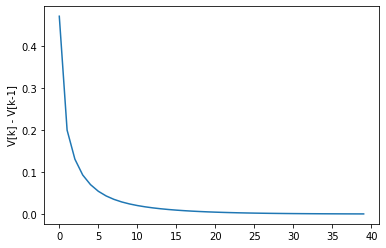

Value Function [0.013796447121892708, 0.011801553061449348, 0.013938978166841792, 0.005942569263546093, 0.0, 0.01864136842788801, 0.0, 0.020866200160313087, 0.0, 0.13824809595197554, 0.02993580165076524, 0.0514227310077103, 0.05569807311990442, 0.11347277854015342, 0.3225795817090483, 0.0, 0.08595416598241772, 0.0, 0.0, 0.6144385721424517, 0.1761162638911322, 0.23529791746477452, 0.3733310022643193, 0.6361185938461882, 0.0]
Policy [0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 3, 1, 2, 0, 0, 0, 0, 2, 1, 1, 1, 1, 0]


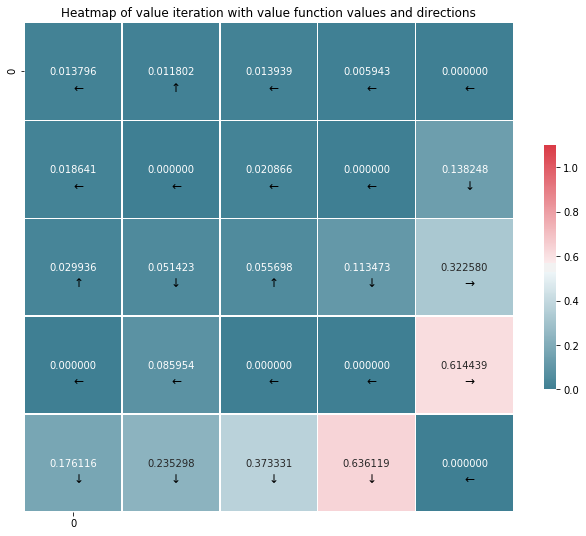


SFFFH
FHFHF
FFFFF
HFHHF
FFFFG


In [17]:
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt
import numpy as np
import math

    # Load a Frozen Lake environment
custom_map =  [
'SFFFH',
'FHFHF',
'FFFFF',
'HFHHF',
'FFFFG'
    ]
    
# Load a Frozen Lake environment
env = gym.make('FrozenLake-v0',desc=custom_map)



def fancy_visual(value_func,policy_int):    
    grid = 5
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = seaborn.diverging_palette(220, 10, as_cmap=True)
    reshaped=np.reshape(value_func,(grid,grid))
    seaborn.heatmap(reshaped, cmap=cmap, vmax=1.1,
                square=True, xticklabels=grid+1, yticklabels=grid+1,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, annot=True, fmt="f")
    counter=0
    for j in range(0, 5):
        for i in range(0, 5):
            if policy_int[counter]==1:
                plt.text(i+0.5, j+0.7, u'\u2193', fontsize=12)
            elif policy_int[counter]==3:
                plt.text(i+0.5, j+0.7, u'\u2191', fontsize=12)
            elif policy_int[counter]==0:
                plt.text(i+0.5, j+0.7, u'\u2190', fontsize=12)
            else:
                plt.text(i+0.5, j+0.7, u'\u2192', fontsize=12)
            counter=counter+1
            
    plt.title('Heatmap of value iteration with value function values and directions')
    print('Value Function',value_func)
    print('Policy',policy_int)
    plt.show()
    
gamma = 0.9
def value_iter(V, P, nA, nS):
    new_V = [0]*nS
    policy = [0]*nS
    for s in range(nS):
        new_v = [0]*nA
        for a in range(nA):
            for prob, next_s, reward, terminal in P[s][a]:
                new_v[a] += prob * (reward + gamma * V[next_s])
        new_V[s] = max(new_v)
        policy[s] = np.argmax(new_v)
    return new_V, policy

def l2(a, b):
    s = 0
    for i in range(len(a)):
        s += (a[i]-b[i])**2
    return math.sqrt(s)

V = [0]*env.nS
policy = None

n_iter = 40
diff = []
for i in range(n_iter):
    new_V, policy = value_iter(V, env.P, env.nA, env.nS)
    diff.append(l2(V, new_V))
    V = new_V

plt.plot(diff)
plt.ylabel('V[k] - V[k-1]')
plt.show()

fancy_visual(V, policy)
env.render()

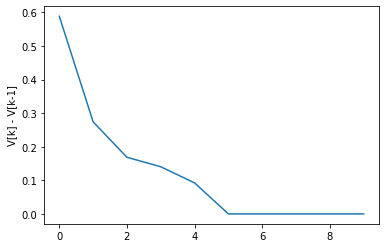

Value Function [0.01442577 0.01231386 0.01430899 0.00613204 0.         0.01923726
 0.         0.02107553 0.         0.13824885 0.03046384 0.05184726
 0.0559437  0.1135572  0.32258065 0.         0.08641825 0.
 0.         0.61443932 0.17715911 0.23621498 0.37401167 0.63648077
 0.        ]
Policy [0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 3, 1, 2, 0, 0, 0, 0, 2, 1, 1, 1, 1, 0]


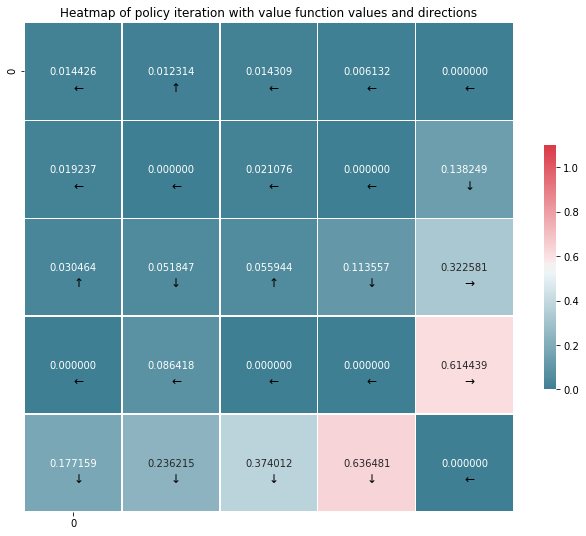


SFFFH
FHFHF
FFFFF
HFHHF
FFFFG


In [18]:
def fancy_visual(value_func,policy_int):    
    grid = 5
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = seaborn.diverging_palette(220, 10, as_cmap=True)
    reshaped=np.reshape(value_func,(grid,grid))
    seaborn.heatmap(reshaped, cmap=cmap, vmax=1.1,
                square=True, xticklabels=grid+1, yticklabels=grid+1,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, annot=True, fmt="f")
    counter=0
    for j in range(0, 5):
        for i in range(0, 5):
            if policy_int[counter]==1:
                plt.text(i+0.5, j+0.7, u'\u2193', fontsize=12)
            elif policy_int[counter]==3:
                plt.text(i+0.5, j+0.7, u'\u2191', fontsize=12)
            elif policy_int[counter]==0:
                plt.text(i+0.5, j+0.7, u'\u2190', fontsize=12)
            else:
                plt.text(i+0.5, j+0.7, u'\u2192', fontsize=12)
            counter=counter+1

    plt.title('Heatmap of policy iteration with value function values and directions')
    print('Value Function',value_func)
    print('Policy',policy_int)
    plt.show()


gamma = 0.9

def eval_policy(policy, P, nA, nS, max_iter=10000, epsilon=1e-6):
    V = np.zeros(nS)
    for i in range(max_iter):
        new_V = np.zeros(nS)
        for s in range(nS):
            for prob, next_s, reward, terminal in P[s][policy[s]]:
                new_V[s] += prob * (reward + gamma * V[next_s])
        if np.max(np.abs(new_V-V)) < epsilon:
            break
        V = new_V
    return new_V

def policy_iter(V, policy, P, nA, nS):
    new_policy = [0]*nS
    for s in range(nS):
        new_v = [0]*nA
        for a in range(nA):
            for prob, next_s, reward, terminal in P[s][a]:
                new_v[a] += prob * (reward + gamma * V[next_s])
        new_policy[s] = np.argmax(new_v)
    return new_policy

def l2(a, b):
    s = 0
    for i in range(len(a)):
        s += (a[i]-b[i])**2
    return math.sqrt(s)

policy = [0]*env.nS
V = eval_policy(policy, env.P, env.nA, env.nS)

n_iter = 10
diff = []
for i in range(n_iter):
    policy = policy_iter(V, policy, env.P, env.nA, env.nS)
    new_V = eval_policy(policy, env.P, env.nA, env.nS)
    diff.append(l2(V, new_V))
    V = new_V

plt.plot(diff)
plt.ylabel('V[k] - V[k-1]')
plt.show()

fancy_visual(V, policy)
env.render()